In [97]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%qtconsole
from IPython.display import display, HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# initiate settings

In [98]:
import pandas as pd
import os
import numpy as np
import pylab as plt
from pylab import show
import re
from utils import vector_dist, digitize, rename_labels, \
                  plot_3d_mean_std_pivot_table, plot_3d_pivot_table, plot_4_2d_pt, \
                  plot_4_4_cdfs, plot_16_cdfs, rollBy, \
                  roll_window_regardless_values, multivector_dist
from scipy.stats import ks_2samp
from pylab import savefig

BASE_DIR = r"D:\Users\Mojo\Google Drive\Technion\project - astrophysics"
DATA_DIR = os.path.join(BASE_DIR, "raw_data")
GRAPHS_DIR = os.path.join(BASE_DIR, "graphs")
pd.set_option('display.width', 1000)

# import stars and planets table

In [99]:
#### stars table ###
stars_path = os.path.join(DATA_DIR, "stars.xlsx")
stars_raw = pd.read_excel(stars_path)
# clean stars with not Age or Teff
stars_raw = stars_raw[stars_raw.Age.notnull()]
stars_raw = stars_raw[stars_raw.Teff.notnull()]
print "Stars:", stars_raw.shape

### planets table ###
planets_path = os.path.join(DATA_DIR, "planets.xlsx")
planets = pd.read_excel(planets_path)
p_raw = planets
num_rows = p_raw.shape[0]
print "Read {:d} planets from file {:s}".format(num_rows, "planets.xlsx")

Stars: (34886, 11)
Read 4706 planets from file planets.xlsx


# cleaning, binning (Teff)

Cleaning planets...
Dropped 0 rows without Age or Teff
Num rows: 980
Dropped 0 rows with teff_34030_8826_diff > 400 (undefined temperature)
Num rows: 980
Dropped 0 rows with koi_period > 5000 days
Num rows: 980
Dropped 0 rows with koi_prad > 15
Num rows: 980
Dropped 0 rows with koi_period > 40
Num rows: 980
KOI Period median: 7.380300042
KOI Period mean: 10.3247419995
Dropped 0 rows with Age > 5000Myr
Num rows: 980
Systems num: 720


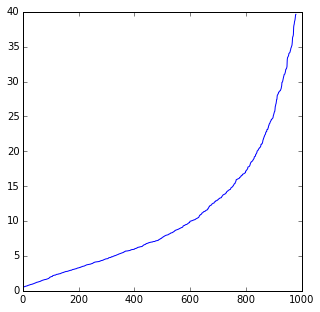

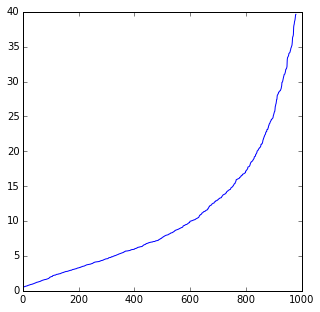

In [115]:
def dffilter(df, condition, num_rows, condition_text=""):
    df = df[condition]
    print "Dropped {:d} rows {:s}".format(num_rows - df.shape[0], condition_text)
    num_rows = df.shape[0]
    print "Num rows: {:d}".format(num_rows)
    return df, num_rows

print "Cleaning planets..."
# only deal with planets with age and temperature
p_raw, num_rows = dffilter(p_raw, p_raw.Age.notnull() & p_raw.Teff.notnull(), 
                           num_rows, "without Age or Teff")
# remove those planets with uncertain temperature (temp-diff < 400K)
p_raw, num_rows = dffilter(p_raw, p_raw.teff_34030_8826_diff.fillna(0) < 400,
                           num_rows, "with teff_34030_8826_diff > 400 (undefined temperature)")
# remove planets with wrong period
p_raw, num_rows = dffilter(p_raw, p_raw.koi_period < 5000, 
                           num_rows, "with koi_period > 5000 days")
# remove planets with huge planetary-radius
p_raw, num_rows = dffilter(p_raw, p_raw.koi_prad < 15, 
                           num_rows, "with koi_prad > 15")


###################################################################
#               Filter planets further than Xdays                 #
###################################################################
vector_dist(p_raw.koi_period)
p_raw, num_rows = dffilter(p_raw, p_raw.koi_period < 40, 
                           num_rows, "with koi_period > 40")
vector_dist(p_raw.koi_period)

print "KOI Period median:", p_raw.koi_period.median()
print "KOI Period mean:", p_raw.koi_period.mean()

# the statistics become really small anyways for planets older than 5000Myr
p_raw, num_rows = dffilter(p_raw, p_raw.Age < 5000, 
                           num_rows, "with Age > 5000Myr")


stars = stars_raw
p = p_raw

###################################################################
#          Bin systems according to temperatures                  #
###################################################################
systems = p[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
print "Systems num:", systems.shape[0]
teff_categories, teff_qbins = pd.qcut(systems.Teff.values, 4, retbins=True)



# Define dataframes (bigger/smaller than threshold)

In [123]:
# Based on the above results, especially the one frequency charts,
# the main conclusion is that the frequency of planets close to the star increases with age.
# CHECK WITH HAGAI: That might lead to a model that with time, planets get closer to the star
# because of angular-momentum transfer to the star. That should only occur with planets close enough to the star.
# If this is true, we would expect to see a non-increasing frequency with planets farther from the star

# define df for planets smaller-bigger than threshold

threshold = 7.38
thresh_type = 'period'
thresh_unit = 'days'
pg = p[p.koi_period > threshold]
pl = p[p.koi_period < threshold]

# threshold = 0.06
# thresh_type = 'sma'
# thresh_unit = 'AU'
# pg = p[p.koi_sma > threshold]
# pl = p[p.koi_sma < threshold]


# define systems-df for each planets-df
systems_g = pg[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
systems_g['multiplicity'] = pg.groupby('KIC').size()
systems_g['teff_bins'] = digitize(systems_g.Teff, teff_qbins)
print "Systems-G num:", systems_g.shape[0]
systems_l = pl[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
systems_l['multiplicity'] = pl.groupby('KIC').size()
systems_l['teff_bins'] = digitize(systems_l.Teff, teff_qbins)
print "Systems-L num:", systems_l.shape[0]


Systems-G num: 401
Systems-L num: 417


### Check if there's a difference in temp (mass) distribution between >7 and < 7

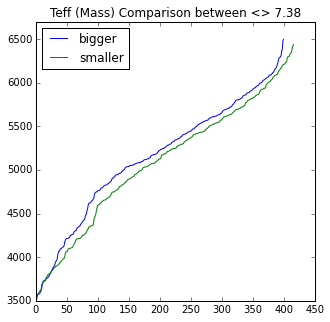

In [124]:
multivector_dist([systems_g.Teff, systems_l.Teff], 
                 title="Teff (Mass) Comparison between <> {}".format(threshold), 
                 labels=["bigger","smaller"])

In [183]:
# Multiplicities of host-systems in the intersection of bigger-smaller
# This is just a verification that we are actually dealing with different planets 
# (If the intersection of planets is not empty we are in a problem...)

kic_i = systems_g.index.intersection(systems_l.index).values
systems_g.loc[kic_i].sort()
systems_l.loc[kic_i].sort()

print "Sanity Check"
print "is the intersection of Bigger-smaller empty?"
print "Total systems in intersection (have planets both in bigger and smaller):", kic_i.shape[0]
print "bigger hist:"
print systems_g.loc[kic_i].multiplicity.value_counts()
print "smaller hist:"
print systems_l.loc[kic_i].multiplicity.value_counts()

print "If the histograms are different than it's fine (it's not the same intersection..)"


Sanity Check
is the intersection of Bigger-smaller empty?
Total systems in intersection (have planets both in bigger and smaller): 98
bigger hist:
1    63
2    30
3     5
dtype: int64
smaller hist:
1    65
2    29
3     3
4     1
dtype: int64
If the histograms are different than it's fine (it's not the same intersection..)


## Estimate Densities of planets

In [279]:
def flat_systems_ages(df):
    """
    Gets a dataframe of systems, each systems might have more than one planet (depend on its multiplicity)
    For each system, "flattens" it to have multiplicity-times its age
    """
    ages = np.zeros(df.multiplicity.sum())
    i = 0
    for ind in xrange(df.shape[0]):
        for age in [df.iloc[ind].Age] * df.iloc[ind].multiplicity:
            ages[i] = df.iloc[ind].Age
            i += 1
    return ages
    
# Overall densities
g_ages = flat_systems_ages(systems_g)
l_ages = flat_systems_ages(systems_l)
all_stars_ages = stars[stars.Age < 5000].Age.values
# Teff bins
g_bins_ages = []
l_bins_ages = []
for teff_bin in xrange(len(teff_categories.categories)):
    qg = systems_g[systems_g.teff_bins==teff_bin+1]
    g_bins_ages.append(flat_systems_ages(qg))
    
    ql = systems_l[systems_l.teff_bins==teff_bin+1]
    l_bins_ages.append(flat_systems_ages(ql))

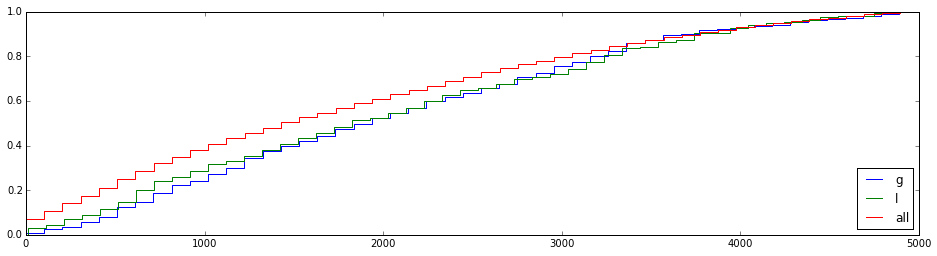

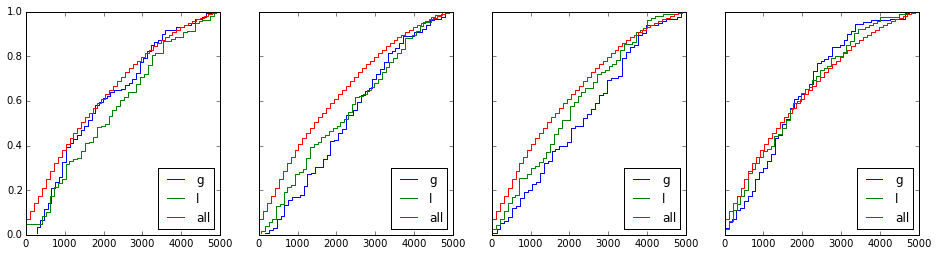

In [283]:
import statsmodels.api as sm

def plot_cdf(samples, labels, ax):
    for i, sample in enumerate(samples):
        ecdf = sm.distributions.ECDF(sample)
        x = np.linspace(min(sample), max(sample))
        y = ecdf(x)
        ax.step(x, y, label=labels[i])
    ax.legend(loc=4)

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(16,4))
plot_cdf([g_ages, l_ages, all_stars_ages], ['g', 'l', 'all'], axes)

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))
for i in xrange(len(teff_categories.categories)):
    plot_cdf([g_bins_ages[i], l_bins_ages[i], all_stars_ages], ['g', 'l', 'all'], axes[i])


In [284]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, bw=bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

print "Package Versions:"
import sklearn; print "  scikit-learn:", sklearn.__version__
import scipy; print "  scipy:", scipy.__version__
import statsmodels; print "  statsmodels:", statsmodels.__version__


Package Versions:
  scikit-learn: 0.16.1
  scipy: 0.16.0
  statsmodels: 0.6.1


In [ ]:
# grid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(, 1, 20)})
# grid.fit(g_ages)
# print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

x = g_ages

kde_skl = KernelDensity(bandwidth=1000)
kde_skl.fit(x[:, np.newaxis])
# score_samples() returns the log-likelihood of the samples
log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
return np.exp(log_pdf)

x_grid = np.linspace(-1000, 6000, 1000)
pdf = kde_skl.score_samples(x_grid[:, None])
# from scipy.stats.distributions import norm

# # The grid we'll use for plotting
# x_grid = np.linspace(-1000, 6000, 1000)
# x = g_ages

# # Plot the three kernel density estimates
# fig, ax = plt.subplots(1, 4, sharey=True, figsize=(13, 3))
# fig.subplots_adjust(wspace=0)

# for i in range(4):
#     pdf = kde_funcs[i](x, x_grid, bandwidth=0.2)
#     ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
#     ax[i].fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4)
#     ax[i].set_title(kde_funcnames[i])
#     ax[i].set_xlim(-4.5, 3.5)
    
# from IPython.display import HTML
# HTML("<font color='#666666'>Gray = True underlying distribution</font><br>"
#      "<font color='6666ff'>Blue = KDE model distribution (500 pts)</font>")


## Compute rolling windows statistics

G
size before filter small windows: 1001
size after filtering small windows: 678
L
size before filter small windows: 1000
size after filtering small windows: 709
size before filter small windows: 400
size after filtering small windows: 242
size before filter small windows: 400
size after filtering small windows: 288
size before filter small windows: 400
size after filtering small windows: 283
size before filter small windows: 400
size after filtering small windows: 300
size before filter small windows: 400
size after filtering small windows: 273
size before filter small windows: 400
size after filtering small windows: 249
size before filter small windows: 400
size after filtering small windows: 199
size before filter small windows: 400
size after filtering small windows: 235


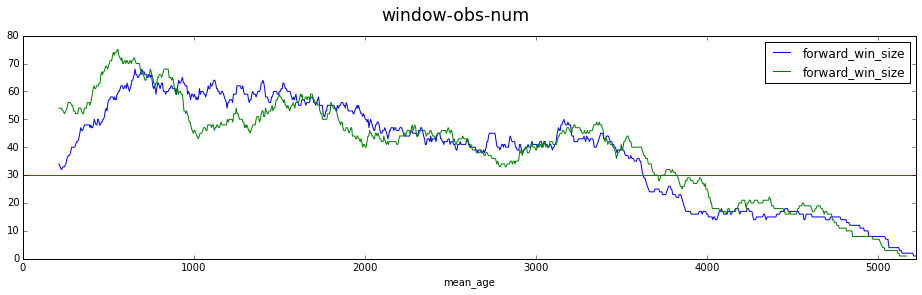

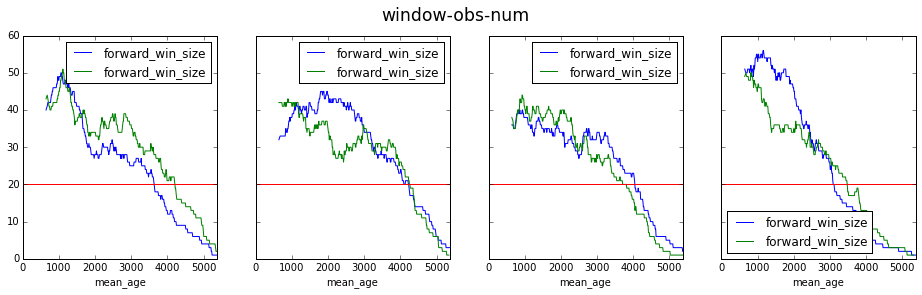

In [125]:
###################################################################
#           Compute runnning window regarding the values          #
###################################################################

# min_window_obs_num = 30

# fig_win_size, axes_win_obs_num = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(16,4))
# fig_win_size.suptitle("window-obs-num", size='xx-large', y=1.08)
# def get_rolling_window(q):
#     q = q.sort('Age')
#     rolling_df = rollBy(q.multiplicity, q.Age, stars, window=1000)
#     rolling_df.plot('mean_age', 'forward_win_size', ax=axes_win_obs_num)
#     print 'size before filter small windows:', rolling_df.shape[0]
#     rolling_df = rolling_df[rolling_df.forward_win_size > min_window_obs_num]
#     print 'size after filtering small windows:', rolling_df.shape[0]
#     return rolling_df

# print "G"
# rolling_df_g = get_rolling_window(systems_g)
# print "L"
# rolling_df_l = get_rolling_window(systems_l)

# max_age = max(rolling_df_g['mean_age'].max(), rolling_df_l['mean_age'].max())

###################################################################
#           Compute runnning window regardless of values          #
###################################################################

def get_rolling_window(q, window_size, num_ticks, min_window_obs_num, ax):
    q = q.sort('Age')
    rolling_df = roll_window_regardless_values(q.multiplicity, q.Age, stars, window_size=window_size, num_ticks=num_ticks)

    # Plot statistics for window samples num
    rolling_df.plot('mean_age', 'forward_win_size', ax=ax)
    print 'size before filter small windows:', rolling_df.shape[0]
    ax.axhline(y=min_window_obs_num, color='r')
    rolling_df = rolling_df[rolling_df.forward_win_size > min_window_obs_num]
    print 'size after filtering small windows:', rolling_df.shape[0]
    
    return rolling_df



###################################################################
#           Compute for Overall                                   #
###################################################################

min_window_obs_num = 30
window_size = 500
num_ticks = 1000

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(16,4))
fig.suptitle("window-obs-num", size='xx-large', y=1.00)
print "G"
rolling_df_g = get_rolling_window(systems_g, window_size, num_ticks, min_window_obs_num, ax=ax)
print "L"
rolling_df_l = get_rolling_window(systems_l, window_size, num_ticks, min_window_obs_num, ax=ax)


###################################################################
#           Compute for bins                                      #
###################################################################

min_window_obs_num = 20
window_size = 1000
num_ticks = 400


fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))
fig.suptitle("window-obs-num", size='xx-large', y=1.00)
teff_rollings = []
for teff_bin in xrange(len(teff_categories.categories)):
    qg = systems_g[systems_g.teff_bins==teff_bin+1]
    ql = systems_l[systems_l.teff_bins==teff_bin+1]

    ax = axes[teff_bin]
    g = get_rolling_window(qg, window_size, num_ticks, min_window_obs_num, ax=ax)
    l = get_rolling_window(ql, window_size, num_ticks, min_window_obs_num, ax=ax)
    
    teff_rollings.append((g, l))


## Compare frequency, multiplicity - overall

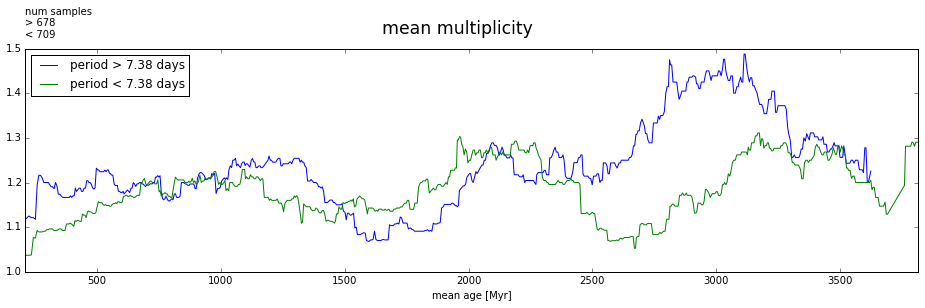

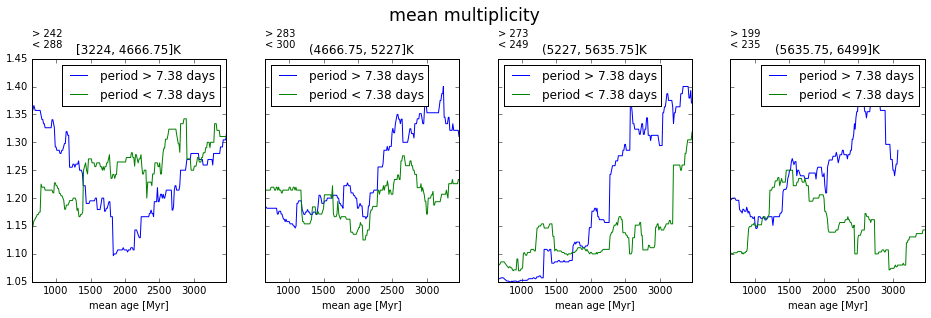

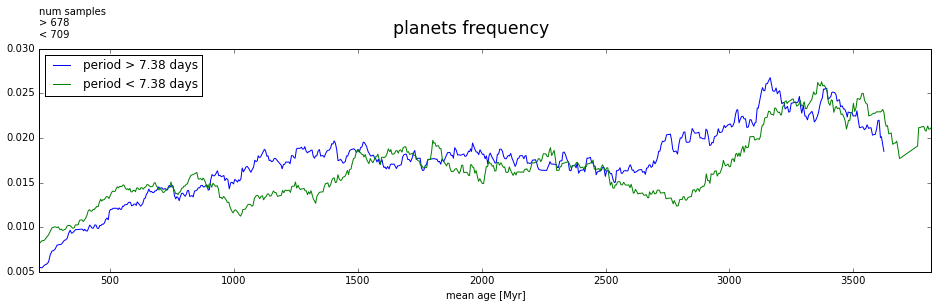

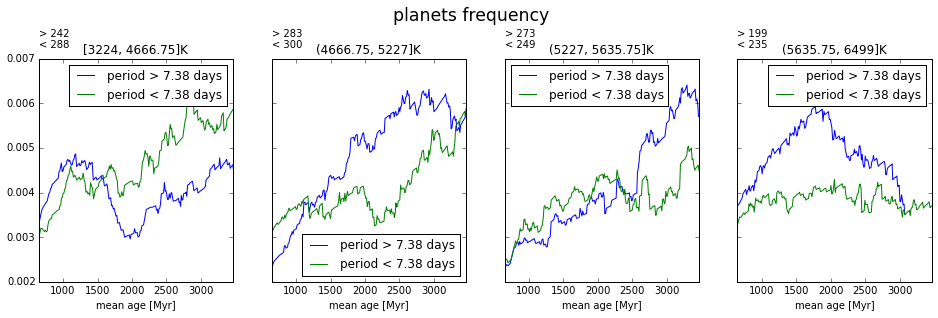

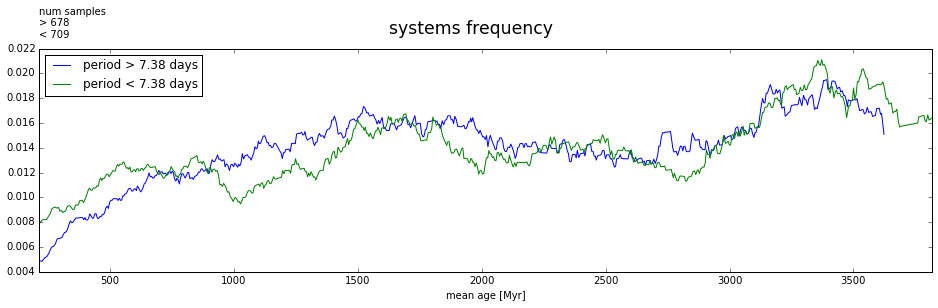

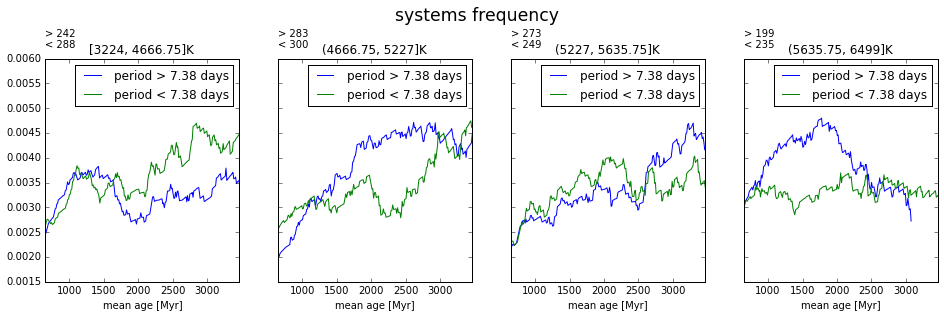

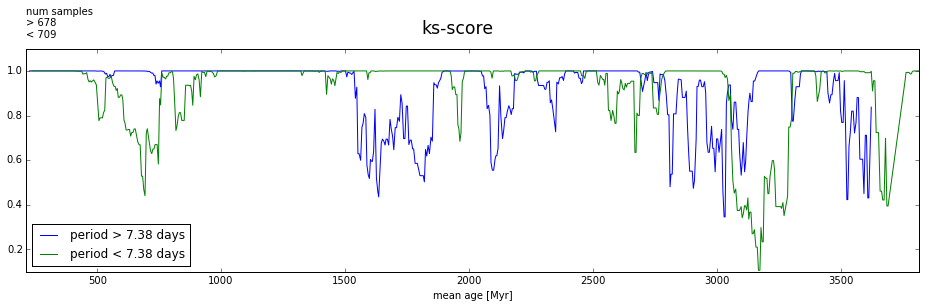

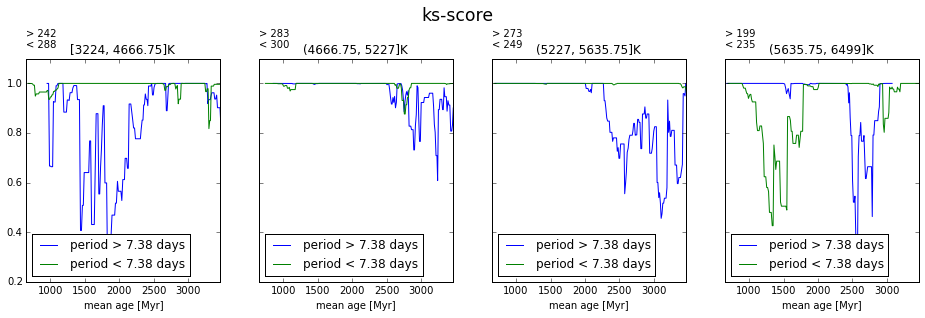

In [126]:
def compare_two_sides(title, g, l, yvalues='mean', saveas='', **kwargs):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(16,4))
    g.plot('mean_age', yvalues, ax=ax, label='{} > {} {}'.format(thresh_type, threshold, thresh_unit))
    l.plot('mean_age', yvalues, ax=ax, label='{} < {} {}'.format(thresh_type, threshold, thresh_unit))
    ax.set_xlabel("mean age [Myr]")
#     # compute ks-score
#     score = ks_2samp(g[yvalues], l[yvalues]).pvalue
#     title = "{:s}\nscore: {}".format(title, score)
    
    fig.suptitle(title, size='xx-large', y=1.00)
    fig.savefig(os.path.join(GRAPHS_DIR, saveas))
    plt.annotate('num samples', xy=(0.00, 1.15), xycoords='axes fraction')
    plt.annotate('> {}'.format(g.shape[0]), xy=(0.00, 1.10), xycoords='axes fraction')
    plt.annotate('< {}'.format(l.shape[0]), xy=(0.00, 1.05), xycoords='axes fraction')

    
def compare_two_sides_bins(title, teff_rollings, yvalues='mean', saveas='', **kwargs):
    fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))
    fig.suptitle(title, size='xx-large', y=1.08)

    for teff_bin in xrange(len(teff_categories.categories)):
        ax = axes[teff_bin]
        
        g = teff_rollings[teff_bin][0]
        l = teff_rollings[teff_bin][1]

        g.plot('mean_age', yvalues, ax=ax, label='{} > {} {}'.format(thresh_type, threshold, thresh_unit))
        l.plot('mean_age', yvalues, ax=ax, label='{} < {} {}'.format(thresh_type, threshold, thresh_unit))
        
        ax.set_title("{}K".format(teff_categories.categories[teff_bin]))
        ax.set_xlabel("mean age [Myr]")
        # ax.annotate('num samples', xy=(0.00, 1.15), xycoords='axes fraction')
        ax.annotate('> {}'.format(g.shape[0]), xy=(0.00, 1.10), xycoords='axes fraction')
        ax.annotate('< {}'.format(l.shape[0]), xy=(0.00, 1.05), xycoords='axes fraction')
    
    fig.savefig(os.path.join(GRAPHS_DIR, saveas))

# rolling_df.plot('mean_age', 'ks-score', title='moving window KS score', logy=True)
compare_two_sides('mean multiplicity', rolling_df_g, rolling_df_l, 'mean', 'comparison_multiplicity.png')
compare_two_sides_bins('mean multiplicity', teff_rollings, 'mean', 'comparison_multiplicity_temp_bins.png')

compare_two_sides('planets frequency', rolling_df_g, rolling_df_l, 'planets-freq', 'comparison_planet_frequency.png')
compare_two_sides_bins('planets frequency', teff_rollings, 'planets-freq', 'comparison_planet_frequency_temp_bins.png')

compare_two_sides('systems frequency', rolling_df_g, rolling_df_l, 'systems-freq', 'comparison_system_frequency.png')
compare_two_sides_bins('systems frequency', teff_rollings, 'systems-freq', 'comparison_system_frequency_temp_bins.png')

compare_two_sides('ks-score', rolling_df_g, rolling_df_l, 'ks-score', 'comparison_ks.png')
compare_two_sides_bins('ks-score', teff_rollings, 'ks-score', 'comparison_ks_temp_bins.png')


### Make Animations

In [127]:
# import numpy as np
# from matplotlib import pyplot as plt
# from matplotlib import animation


# fig = plt.figure()
# ax = plt.axes(xlim=(0, 3500), ylim=(0, 0.03))
# line, = ax.plot([], [], lw=2)

# ### Parameters ###
# min_window_obs_num = 30
# window_size = 500
# num_ticks = 1000

# def get_rolling_window(q, window_size, num_ticks, min_window_obs_num):
#     q = q.sort('Age')
#     rolling_df = roll_window_regardless_values(q.multiplicity, q.Age, stars, window_size=window_size, num_ticks=num_ticks)
#     rolling_df = rolling_df[rolling_df.forward_win_size > min_window_obs_num]
#     return rolling_df

# def animate(frame):

#     print ">>>>>>>>>>", frame
#     thresholds = [6.7, 7, 7.3]
    
#     ### Define the threshold ###
#     threshold = thresholds[frame]
#     thresh_type = 'period'
#     thresh_unit = 'days'
#     yvalues = 'planets-freq'
#     title = 'planets frequency'
    
#     # define df for planets smaller-bigger than threshold
#     pg = p[p.koi_period > threshold]
#     pl = p[p.koi_period < threshold]
#     # define systems-df for each planets-df
#     systems_g = pg[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
#     systems_g['multiplicity'] = pg.groupby('KIC').size()
#     systems_g['teff_bins'] = digitize(systems_g.Teff, teff_qbins)
#     systems_l = pl[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
#     systems_l['multiplicity'] = pl.groupby('KIC').size()
#     systems_l['teff_bins'] = digitize(systems_l.Teff, teff_qbins)
#     ### Compute rolling windows ###
#     g = get_rolling_window(systems_g, window_size, num_ticks, min_window_obs_num)
#     l = get_rolling_window(systems_l, window_size, num_ticks, min_window_obs_num)

#     x = g['mean_age'].values
#     y = g[yvalues].values
#     line.set_data(x, y)
#     return line,    
        
# #     im1 = g.plot('mean_age', yvalues, label='{} > {} {}'.format(thresh_type, threshold, thresh_unit))
# #     im2 = l.plot('mean_age', yvalues, label='{} < {} {}'.format(thresh_type, threshold, thresh_unit))
# #     plt.set_xlabel("mean age [Myr]")
# #     plt.title(title, size='xx-large', y=1.00)
    
# #     plt.annotate('num samples', xy=(0.00, 1.15), xycoords='axes fraction')
# #     plt.annotate('> {}'.format(g.shape[0]), xy=(0.00, 1.10), xycoords='axes fraction')
# #     plt.annotate('< {}'.format(l.shape[0]), xy=(0.00, 1.05), xycoords='axes fraction')

    
# def init():
#     line.set_data([], [])
#     return line,
    
# anim = animation.FuncAnimation(fig, animate, init_func=init, frames=3, interval=1000, blit=True)

# # anim.save('planets-freq_threshold.mp4', fps=1, extra_args=['-vcodec', 'libx264'])

# # plt.show()




In [128]:
# #run animation
# zz = ims
# fig = plt.figure()
# ani = animation.ArtistAnimation(fig,ims, interval=50,blit=False)
# plt.show()

# # anim = animation.FuncAnimation(fig, animate, init_func=init,
# #                                frames=200, interval=20, blit=True)
# ani.save('planets-freq_threshold.mp4', fps=1, extra_args=['-vcodec', 'libx264'])

In [129]:
# import numpy as np
# from matplotlib import pyplot as plt
# from matplotlib import animation


# ### Parameters ###
# min_window_obs_num = 20
# window_size = 1500
# num_ticks = 400

# ### Define the thrshold ###
# threshold = 7
# thresh_type = 'period'
# thresh_unit = 'days'
# # define df for planets smaller-bigger than threshold
# pg = p[p.koi_period > threshold]
# pl = p[p.koi_period < threshold]
# # define systems-df for each planets-df
# systems_g = pg[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
# systems_g['multiplicity'] = pg.groupby('KIC').size()
# systems_g['teff_bins'] = digitize(systems_g.Teff, teff_qbins)
# systems_l = pl[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
# systems_l['multiplicity'] = pl.groupby('KIC').size()
# systems_l['teff_bins'] = digitize(systems_l.Teff, teff_qbins)

# ### Compute rolling windows ###
# fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))
# fig.suptitle("window-obs-num", size='xx-large', y=1.00)
# teff_rollings = []
# for teff_bin in xrange(len(teff_categories.categories)):
#     qg = systems_g[systems_g.teff_bins==teff_bin+1]
#     ql = systems_l[systems_l.teff_bins==teff_bin+1]

#     ax = axes[teff_bin]
#     g = get_rolling_window(qg, window_size, num_ticks, min_window_obs_num, ax=ax)
#     l = get_rolling_window(ql, window_size, num_ticks, min_window_obs_num, ax=ax)
    
#     teff_rollings.append((g, l))


# ### Compute the plots.. ###
# def compare_two_sides_bins(title, teff_rollings, yvalues='mean', saveas='', **kwargs):
#     fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))
#     fig.suptitle(title, size='xx-large', y=1.08)

#     for teff_bin in xrange(len(teff_categories.categories)):
#         ax = axes[teff_bin]
        
#         g = teff_rollings[teff_bin][0]
#         l = teff_rollings[teff_bin][1]

#         g.plot('mean_age', yvalues, ax=ax, label='{} > {} {}'.format(thresh_type, threshold, thresh_unit))
#         l.plot('mean_age', yvalues, ax=ax, label='{} < {} {}'.format(thresh_type, threshold, thresh_unit))
        
#         ax.set_title("{}K".format(teff_categories.categories[teff_bin]))
#         ax.set_xlabel("mean age [Myr]")
#         # ax.annotate('num samples', xy=(0.00, 1.15), xycoords='axes fraction')
#         ax.annotate('> {}'.format(g.shape[0]), xy=(0.00, 1.10), xycoords='axes fraction')
#         ax.annotate('< {}'.format(l.shape[0]), xy=(0.00, 1.05), xycoords='axes fraction')
    
#     fig.savefig(os.path.join(GRAPHS_DIR, saveas))

# compare_two_sides_bins('planets frequency', teff_rollings, 'planets-freq', 'comparison_planet_frequency_temp_bins.png')

    
    
# def init():


    
# fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))


# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=200, interval=20, blit=True)
# anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
